In [1]:
import pickle, os, gzip, json
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import pynndescent
from sklearn.feature_extraction.text import TfidfTransformer
import umap
import scipy as sp

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300

import sys
sys.path.append("../../scripts")

## Load data

In [2]:
import data_io
reload(data_io)
from data_io import is_fwd_id, get_fwd_id, get_sibling_id

import nearest_neighbors
reload(nearest_neighbors)
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
)

import graph
reload(graph)
from graph import ReadGraph, GenomicInterval

import truth
reload(truth)
from truth import get_overlaps

import evaluate
reload(evaluate)
from evaluate import NearestNeighborsConfig, mp_evaluate_configs


/home/ecs-user/workspace/kNN-overlap-finder/scripts/../lib


In [3]:
sample = "CHM13"
region = "HLA"
dataset = "pbsim_ONT_93_30k"

sample_size = 6_000

prefix = f"../../data/feature_matrix/kmer/{sample}/{region}/{dataset}/"

npz_path = os.path.join(prefix, "feature_matrix.npz")
tsv_path = os.path.join(prefix, "metadata.tsv.gz")
json_path = os.path.join(prefix, "read_features.json.gz")

meta_df = pd.read_table(tsv_path).iloc[:sample_size, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}

feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

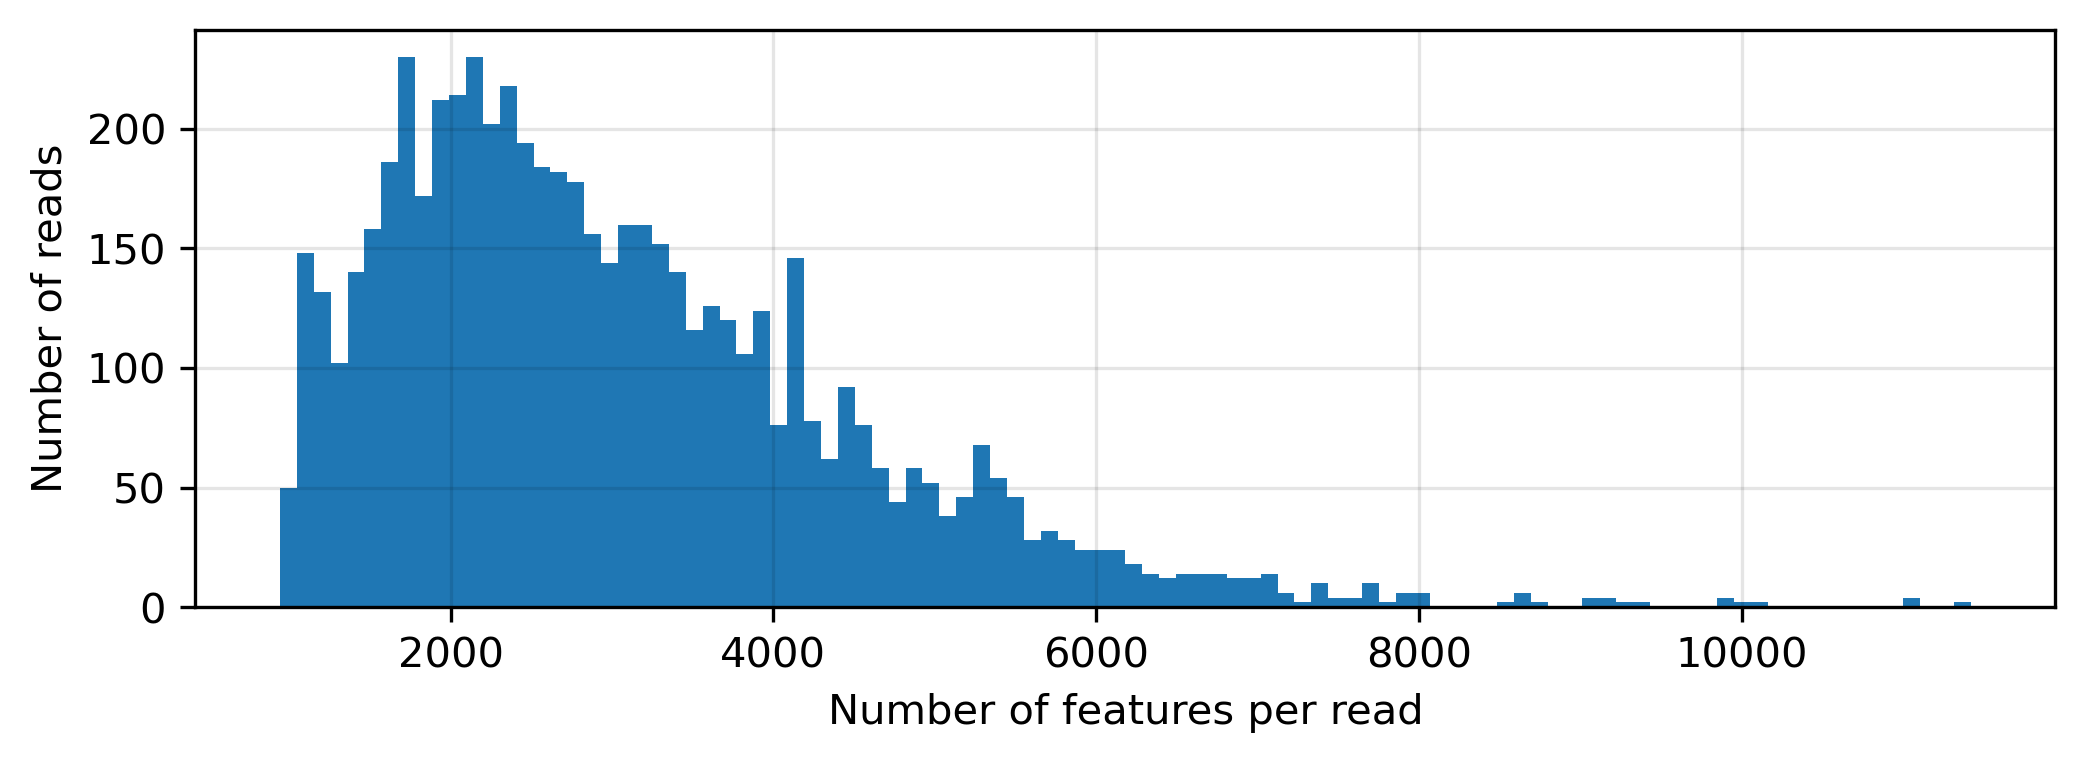

In [4]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.hist([len(x) for x in read_features.values()], bins=100);
ax.set_xlabel("Number of features per read")
ax.set_ylabel("Number of reads")
ax.grid(color='k', alpha=0.1)

In [5]:
feature_matrix.shape

(6000, 102827)

In [6]:
feature_matrix.sum() / (feature_matrix.shape[0] * feature_matrix.shape[1])

0.029775989445054964

In [7]:
meta_df

index  read_id read_name read_orientation  read_length reference_strand  \
0         0        0      S1_1                +        11173                +   
1         1        1      S1_1                -        11173                -   
2         2        2      S1_2                +        21867                -   
3         3        3      S1_2                -        21867                +   
4         4        4      S1_3                +        20111                +   
...     ...      ...       ...              ...          ...              ...   
5995   5995     5995   S1_2998                -        45206                +   
5996   5996     5996   S1_2999                +        42316                +   
5997   5997     5997   S1_2999                -        42316                -   
5998   5998     5998   S1_3000                +        25035                -   
5999   5999     5999   S1_3000                -        25035                +   

      reference_start  reference_end  
0             2542359        2553531  
1             2542359        2553531  
2             1440944        1462940  
3             1440944        1462940  
4             3928115        3948925  
...               ...            ...  
5995          5355291        5403268  
5996           677500         720260  
5997           677500         720260  
5998          2429252        2454489  
5999          2429252        2454489  

[6000 rows x 8 columns]

In [8]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
len(read_intervals)

6000

In [9]:
reference_graph = ReadGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(6000, 98678, 11468, 2)

## Get nearest neighbours

In [10]:
import nearest_neighbors

reload(nearest_neighbors)
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    PAFNearestNeighbors,
    LowHash,
    _NearestNeighbors,
)

import graph

reload(graph)
from graph import ReadGraph, GenomicInterval

import evaluate

reload(evaluate)
from evaluate import NearestNeighborsConfig, mp_evaluate_configs

In [11]:
config_list = [
    NearestNeighborsConfig(
        method=LowHash,
        use_tfidf=False,
        n_neighbors=12,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=LowHash,
        use_tfidf=False,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=None,
        n_neighbors=12,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=None,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=12,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    
]

In [12]:
config_list = [
    NearestNeighborsConfig(
        method=LowHash,
        use_tfidf=False,
        n_neighbors=12,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=12,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            use_weights=False,
            seed=458,
        ),
    ),
    
    
]

In [13]:
paf_path = f"../../data/minimap2/{sample}/{region}/{dataset}/alignment.gaf.gz"

configs = [
    NearestNeighborsConfig(
        method=PAFNearestNeighbors,
        n_neighbors=6,
        nearest_neighbor_kw=dict(paf_path=paf_path, read_indices=read_indices),
    ),
    NearestNeighborsConfig(
        method=LowHash,
        use_tfidf=False,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=True,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=None,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=100,
        n_neighbors=6,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(metric="euclidean"),
    ),
]

In [14]:
%%time
pickle_file = f"data/pickle/{sample}_{region}_{dataset}_alignment_dict.pickle.gz"
configs = mp_evaluate_configs(
    configs,
    alignment_pickle_path=pickle_file,
    feature_matrix=feature_matrix,
    feature_weights=feature_weights,
    read_features=read_features,
    pairwise_alignment=False,
    post_align_n_neighbors=100,
    processes=8,
    batch_size=1_000,
    reference_graph=reference_graph,
)

0 0 NearestNeighborsConfig(method=<class 'nearest_neighbors.PAFNearestNeighbors'>, use_tfidf=False, dim_reduction=None, n_neighbors=6, elapsed_time=9.89177656173706, require_mutual_neighbors=False, pre_align_stats={'precision': 0.969291761859965, 'nr_precision': 0.23222685122967343, 'recall': 0.29236506617483127, 'nr_recall': 0.6027206138821067, 'singleton_count': 0, 'N50': 6000}, post_align_intersect=False, post_align_stats=None)
Pre-alignment:
precision=0.969 nr_precision=0.232 recall=0.292 nr_recall=0.603 

0 1000 1000 NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, use_tfidf=True, dim_reduction=None, n_neighbors=6, elapsed_time=55.34253406524658, require_mutual_neighbors=False, pre_align_stats={'precision': 0.9995572478526521, 'nr_precision': 0.3186044452315594, 'recall': 0.22878453150651615, 'nr_recall': 0.627485176142309, 'singleton_count': 0, 'N50': 1715}, post_align_intersect=False, post_align_stats=None)
Pre-alignment:
precision=1.000 nr_precis

## Visualisation

In [15]:
# Plots
import plots
reload(plots)
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

In [16]:
def remove_singletons(graph):
    singletons = []
    for node in graph.nodes:
        if len(graph[node]) <= 1:
            singletons.append(node)
    graph.remove_nodes_from(singletons)

def plot_configs(configs, reference_graph, metadata, *, show_singletons=False, **kw):
    graphs = [config.pre_align_graph for config in configs]
    graphs = [g.copy() for g in graphs if g is not None]
    
    for g in graphs:
        remove_singletons(g)
        

    figures, axes = mp_plot_read_graphs(
        graphs, reference_graph=reference_graph, metadata=metadata, **kw
    )
    for ax, config in zip(axes, configs):
        ax.text(
            0, 0, str(config), ha="left", va="bottom", transform=ax.transAxes, wrap=True
        )
        ax.axis("off")


    graphs = [config.post_align_graph for config in configs] + [reference_graph]
    graphs = [g.copy() for g in graphs if g is not None]

    for g in graphs:
        remove_singletons(g)
    
    figures, axes = mp_plot_read_graphs(
        graphs, reference_graph=reference_graph, metadata=metadata, **kw
    )
    for ax, config in zip(axes, configs):
        ax.text(
            0, 0, str(config), ha="left", va="top", transform=ax.transAxes, wrap=True
        )
        ax.axis("off")

0 4 3 5 2 1 
0 
CPU times: user 21.7 s, sys: 749 ms, total: 22.4 s
Wall time: 57.3 s


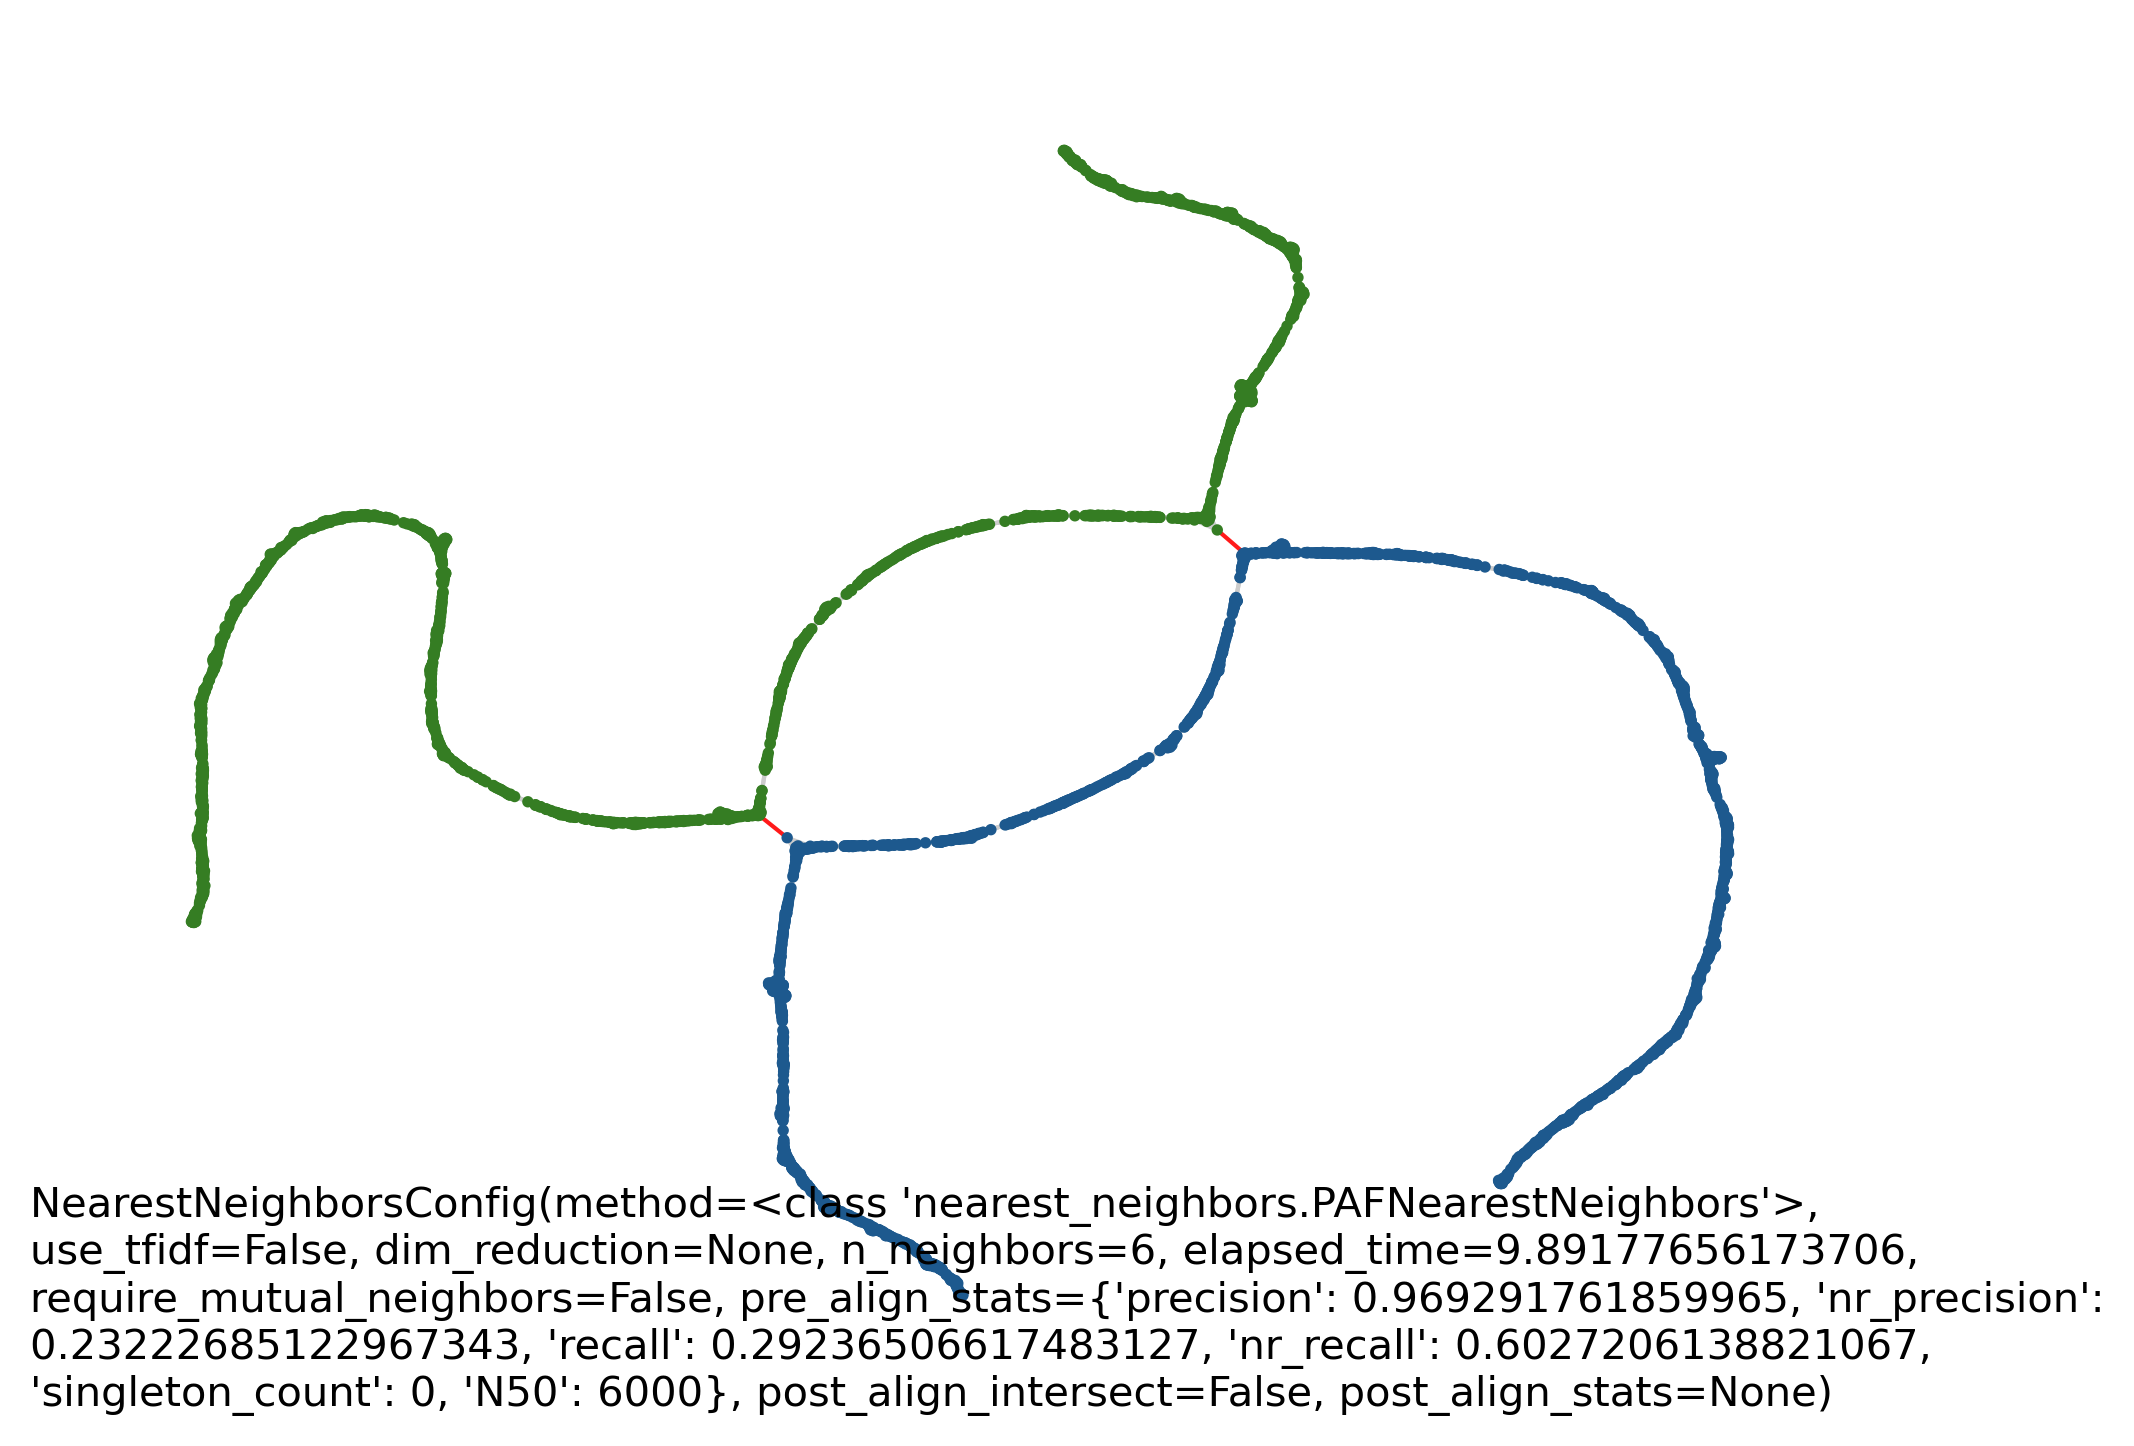

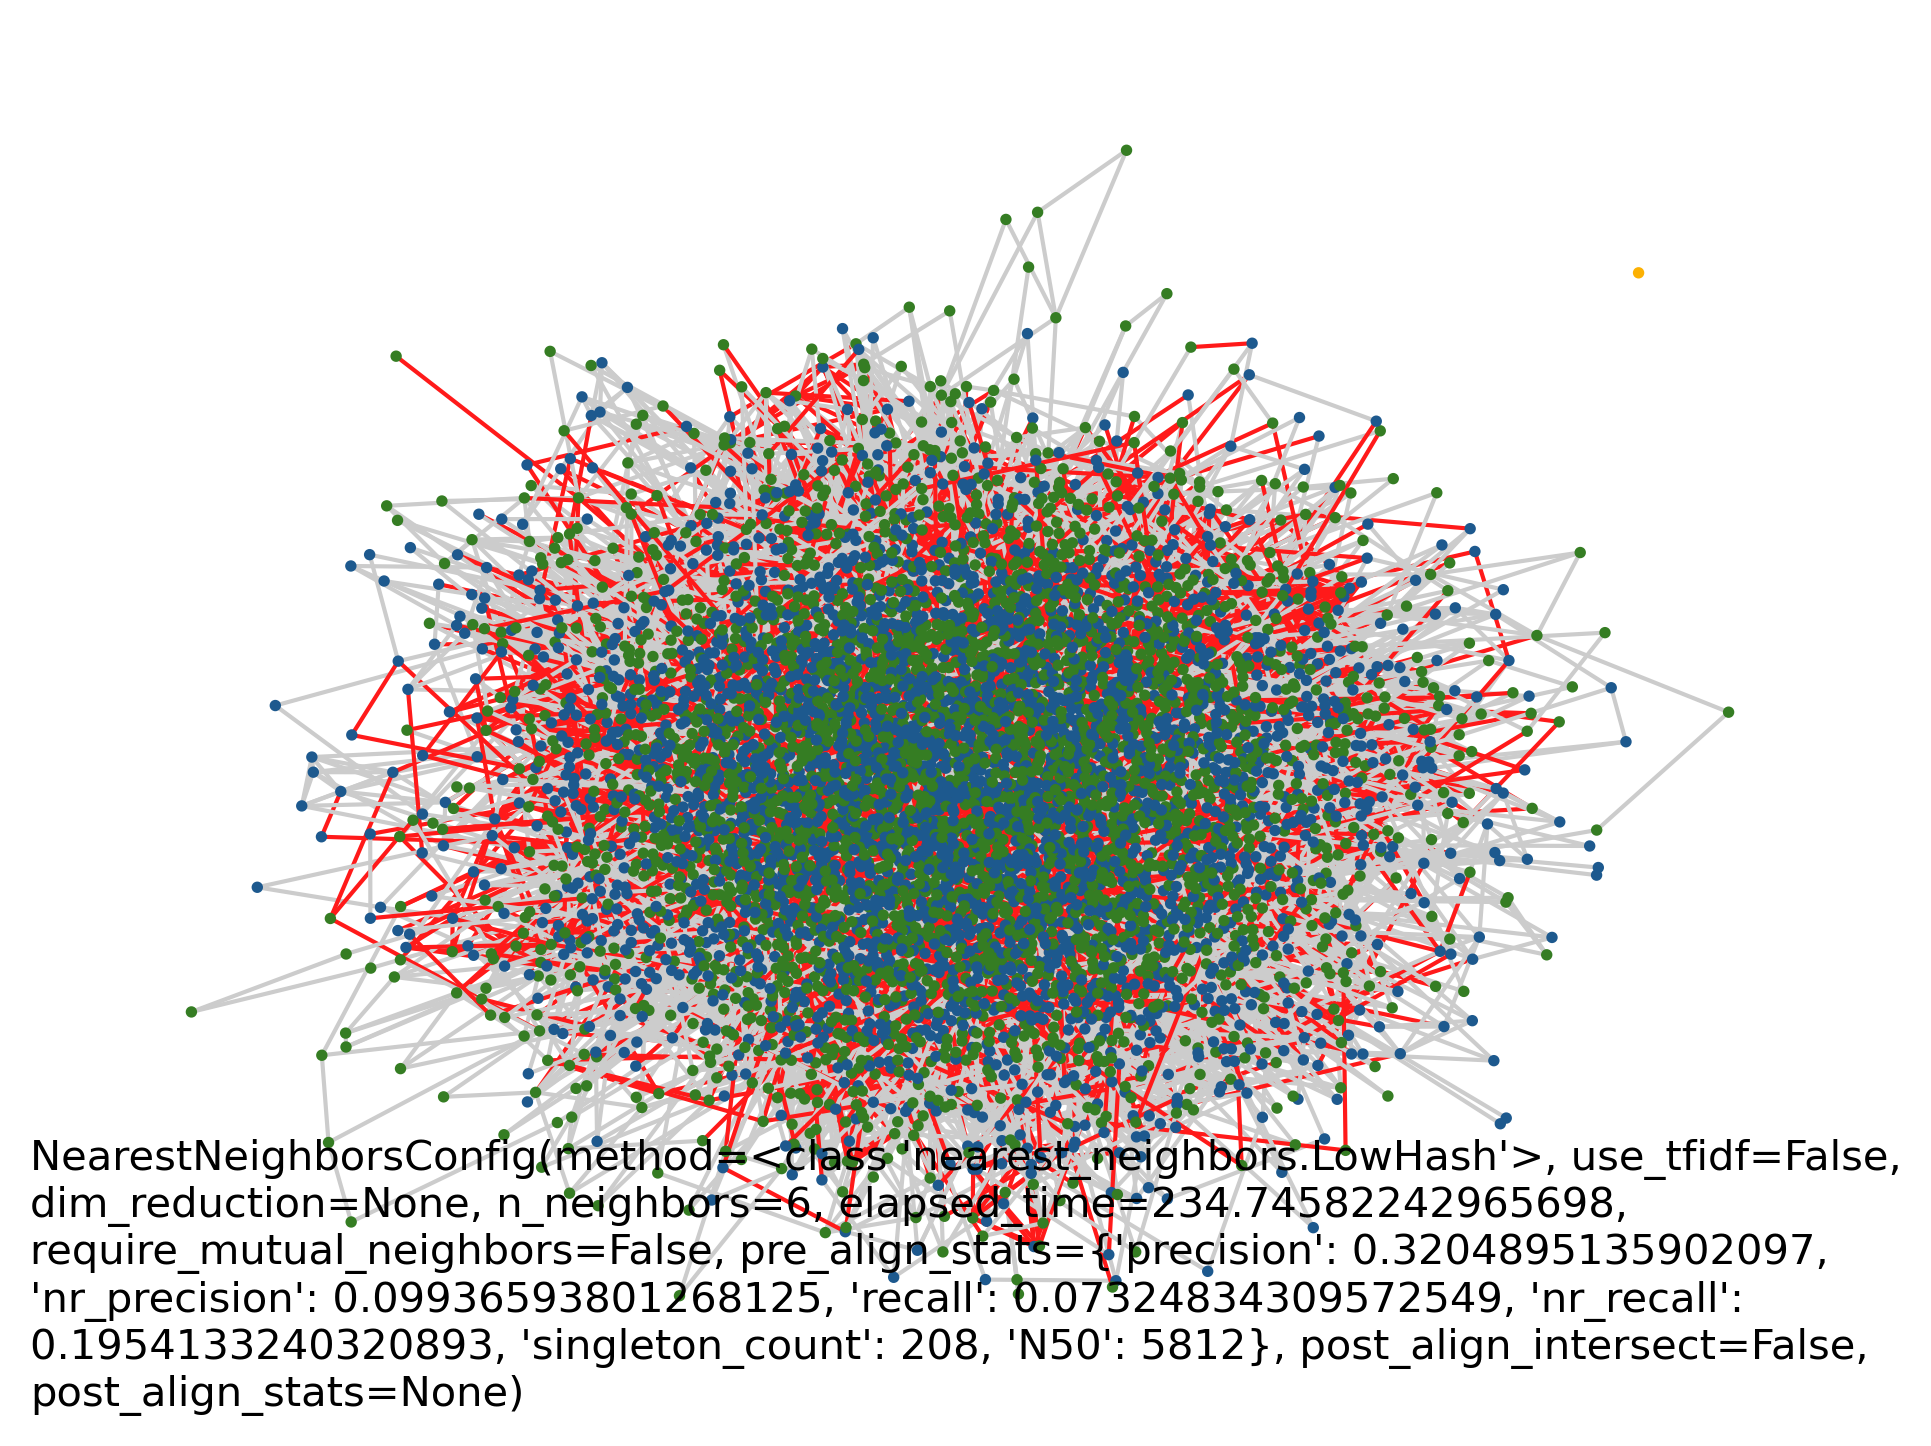

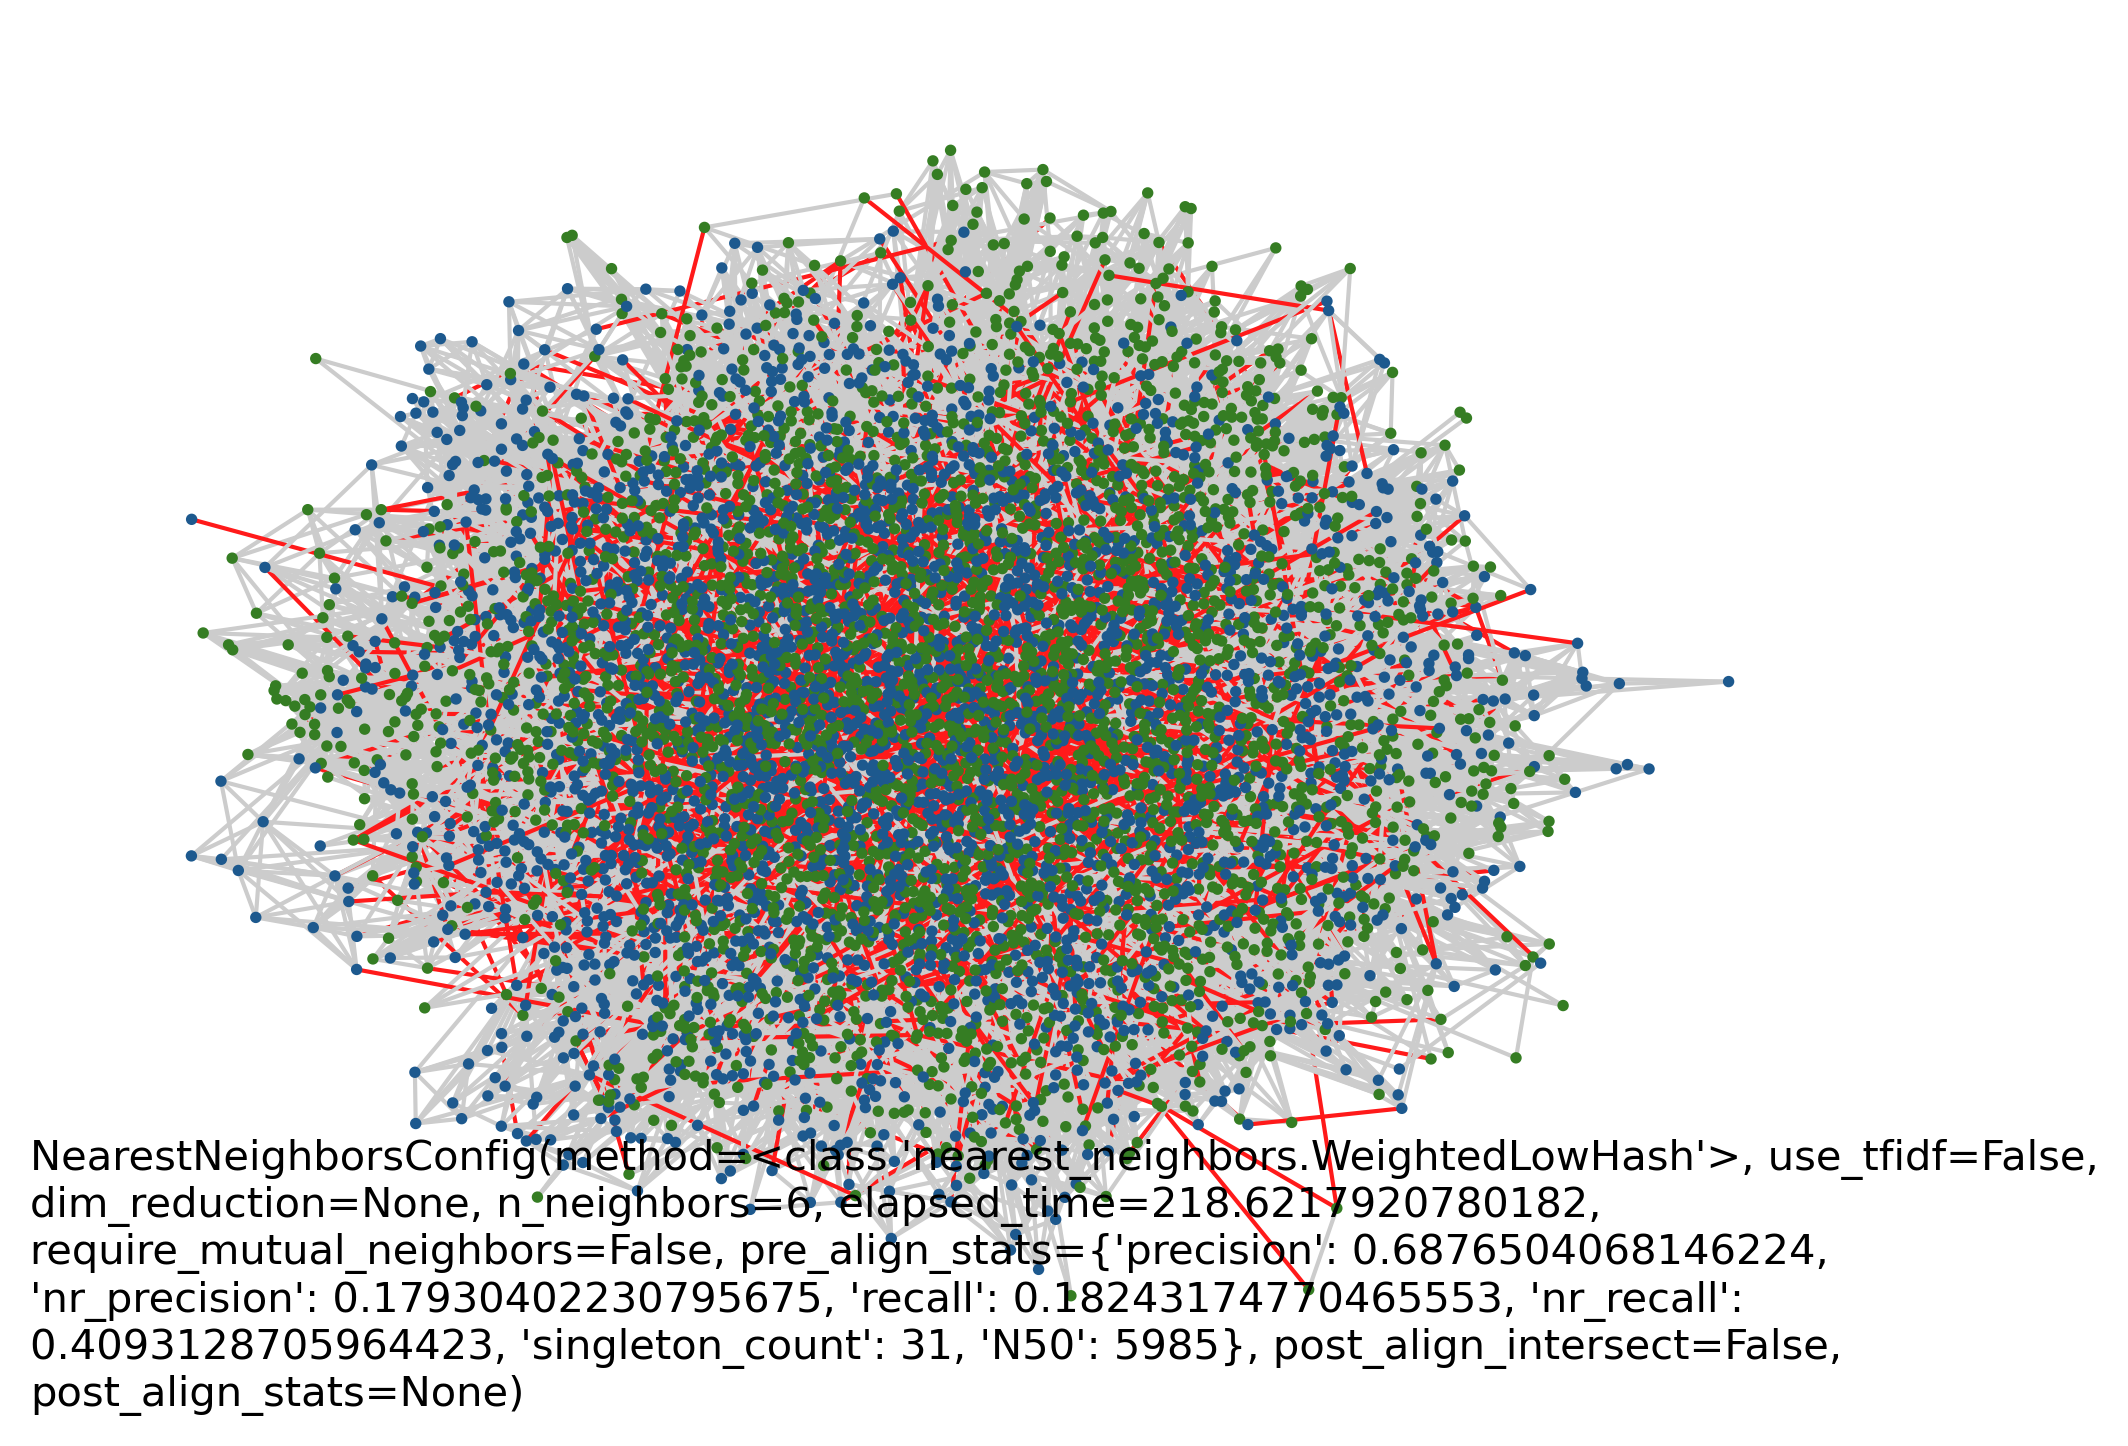

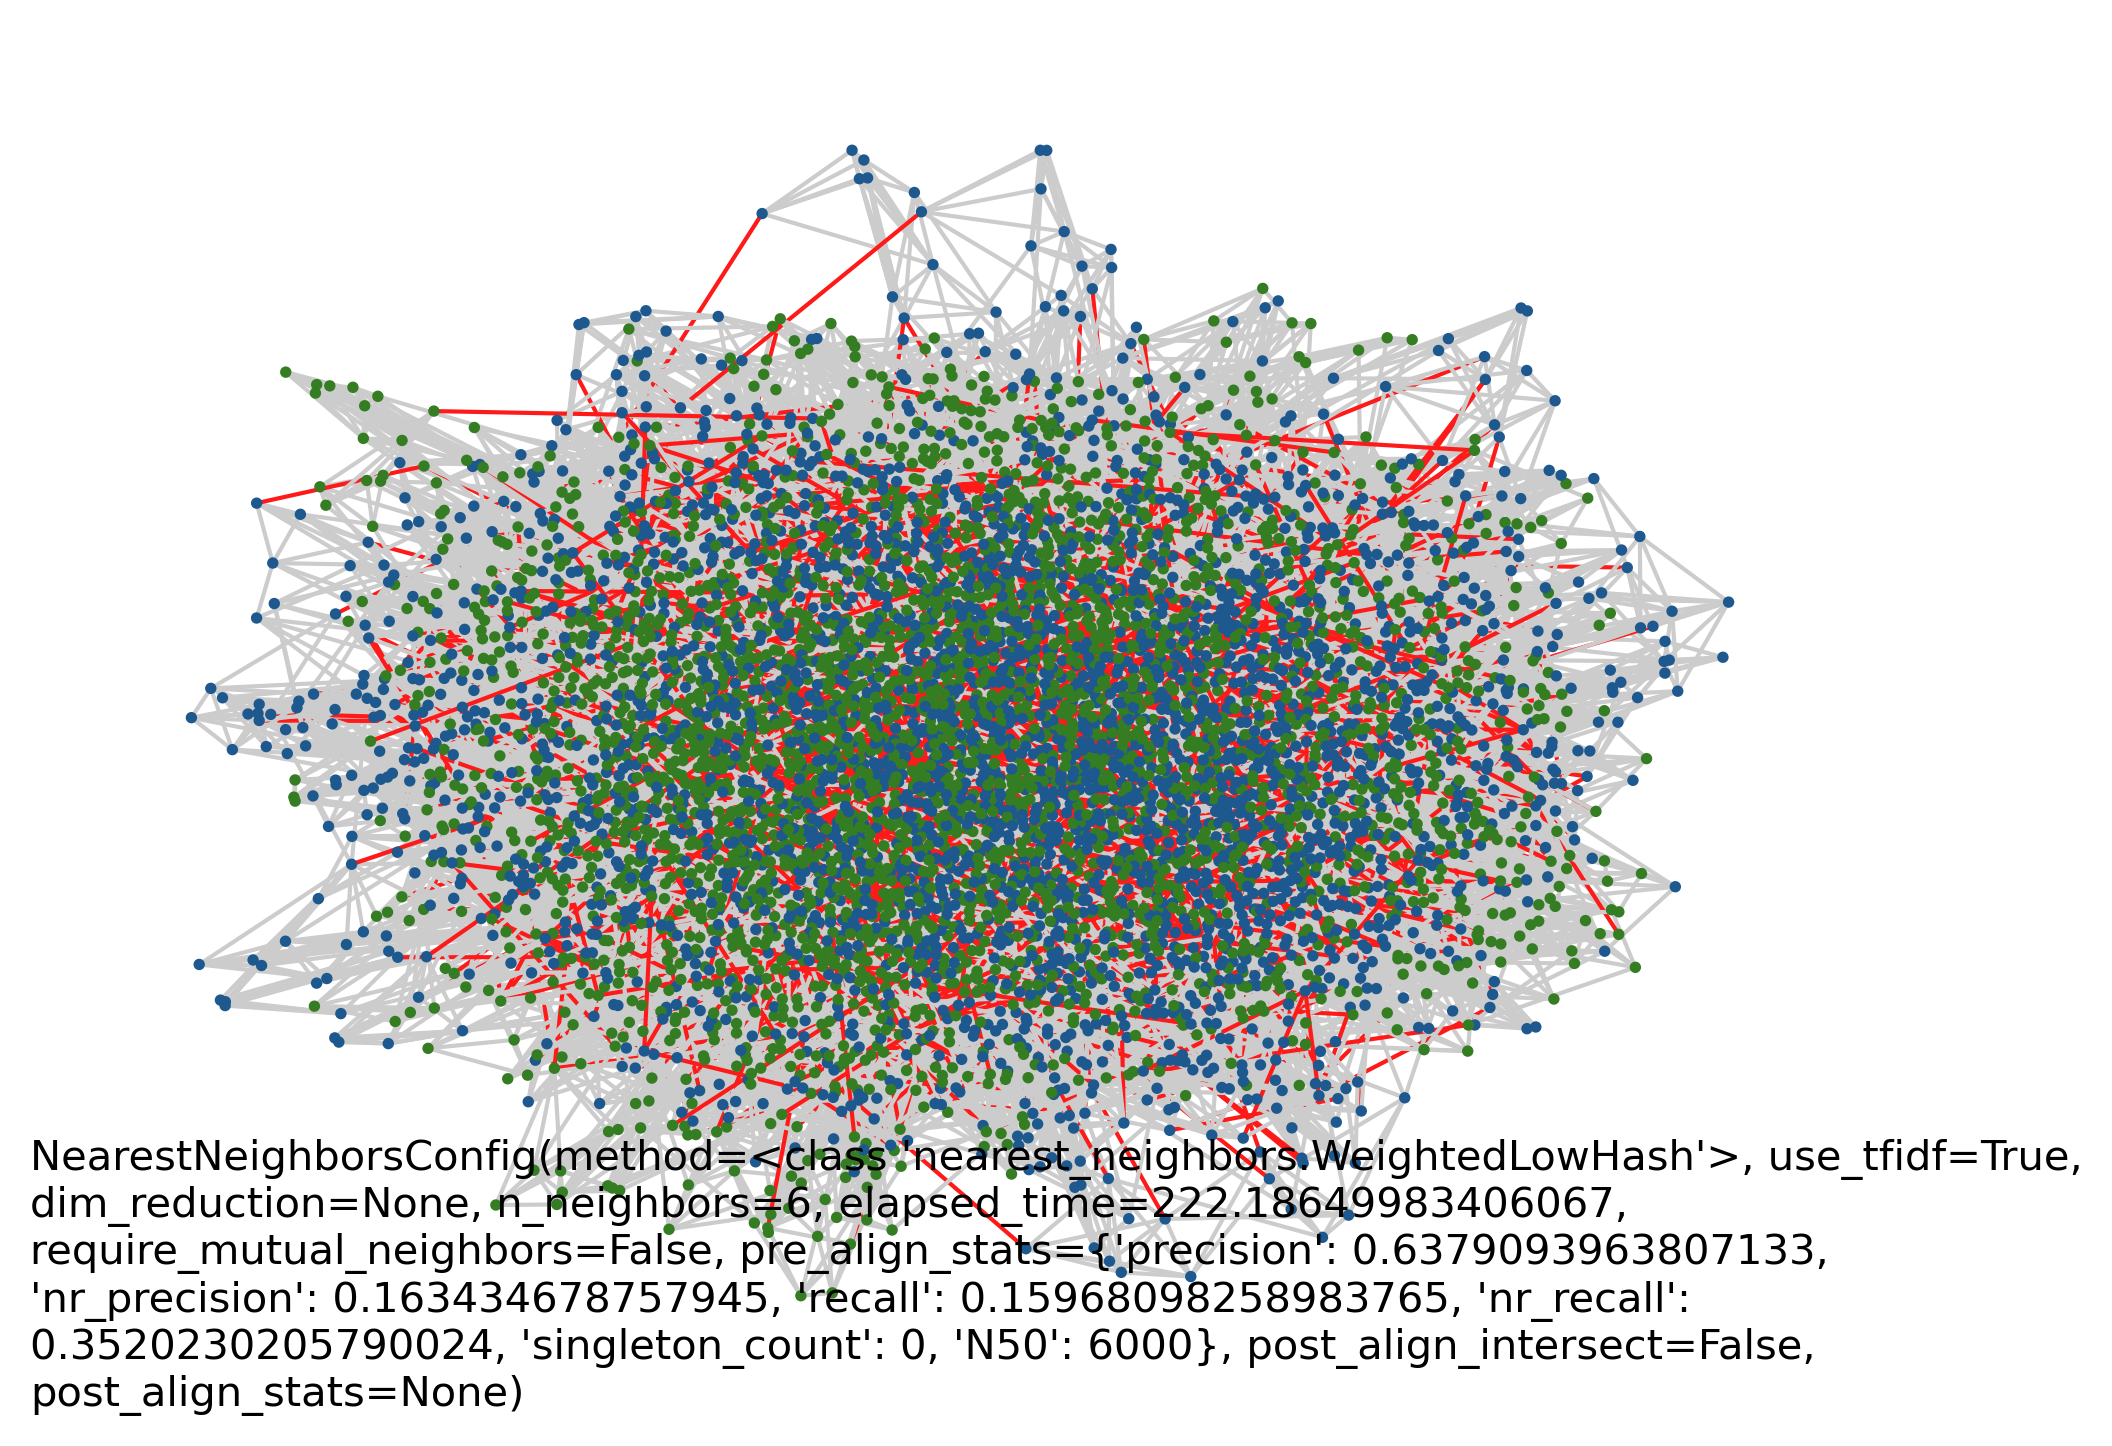

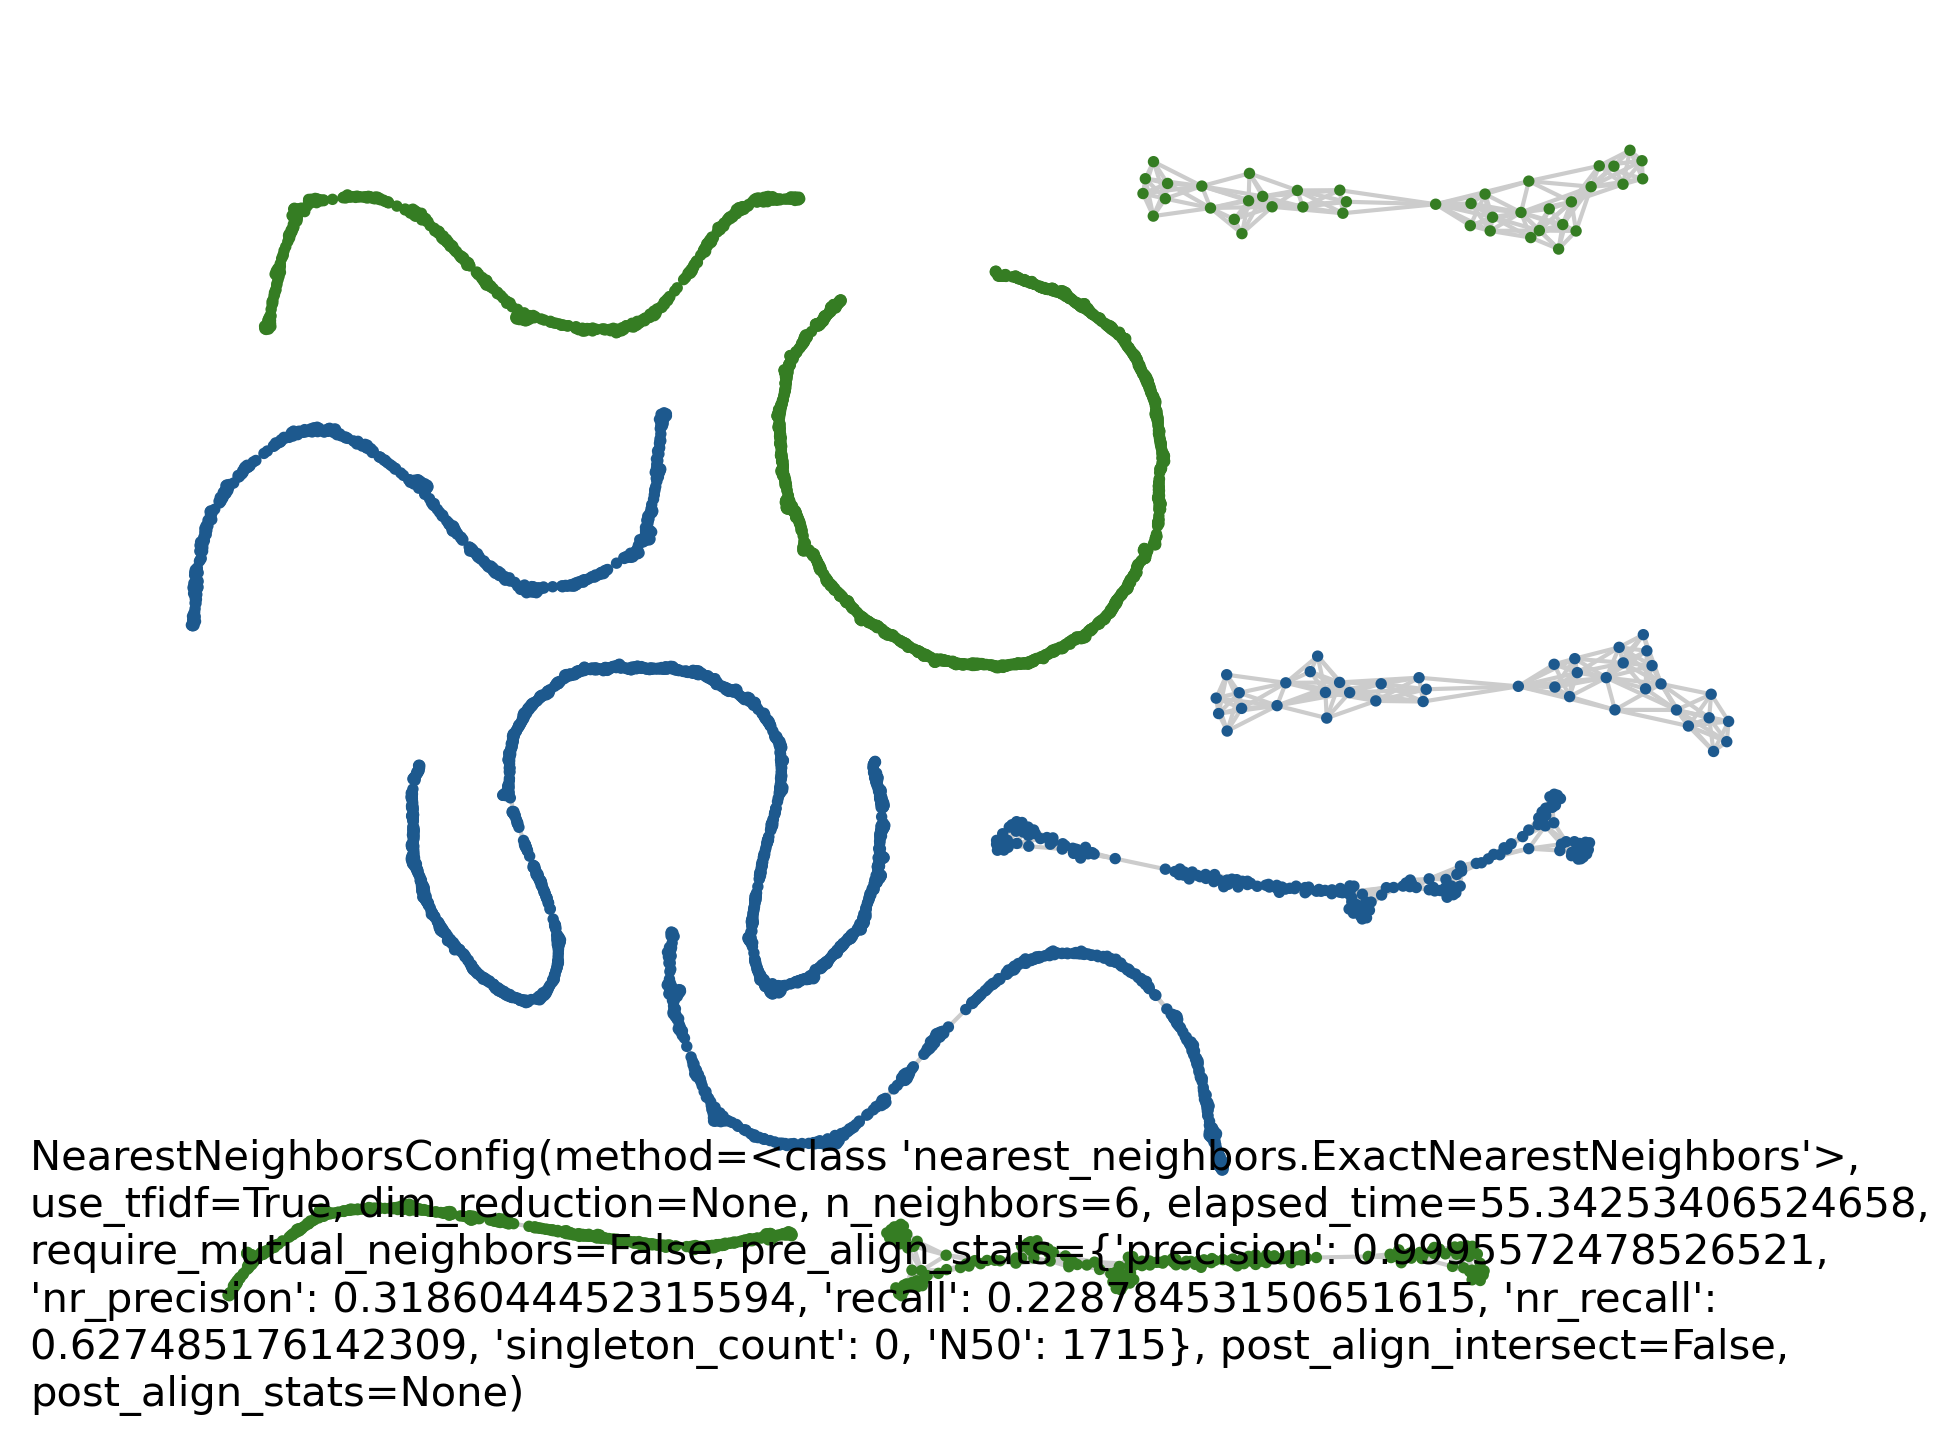

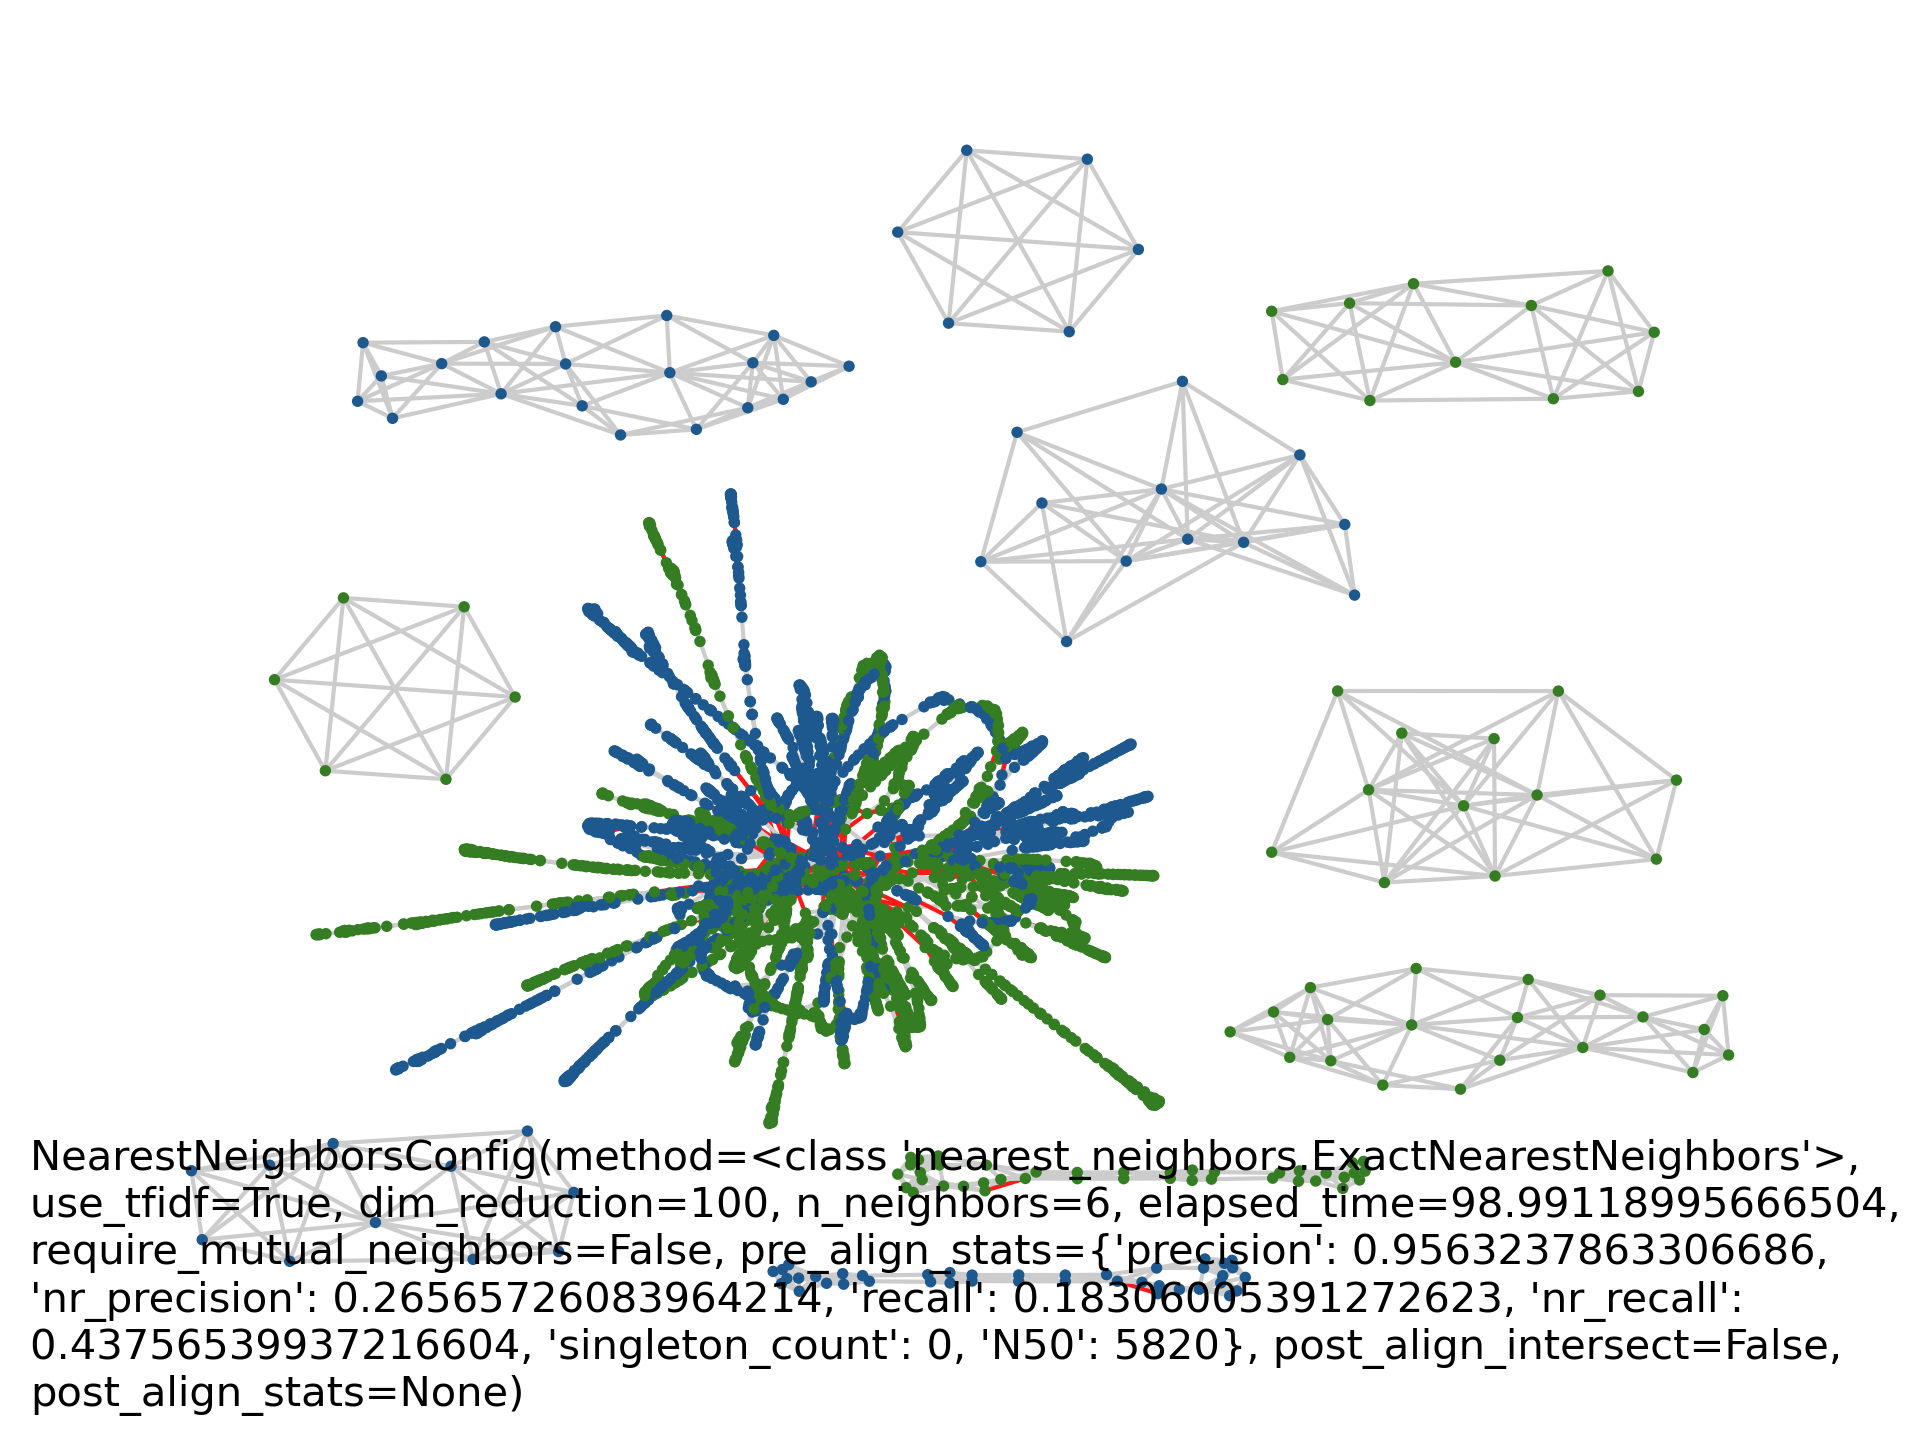

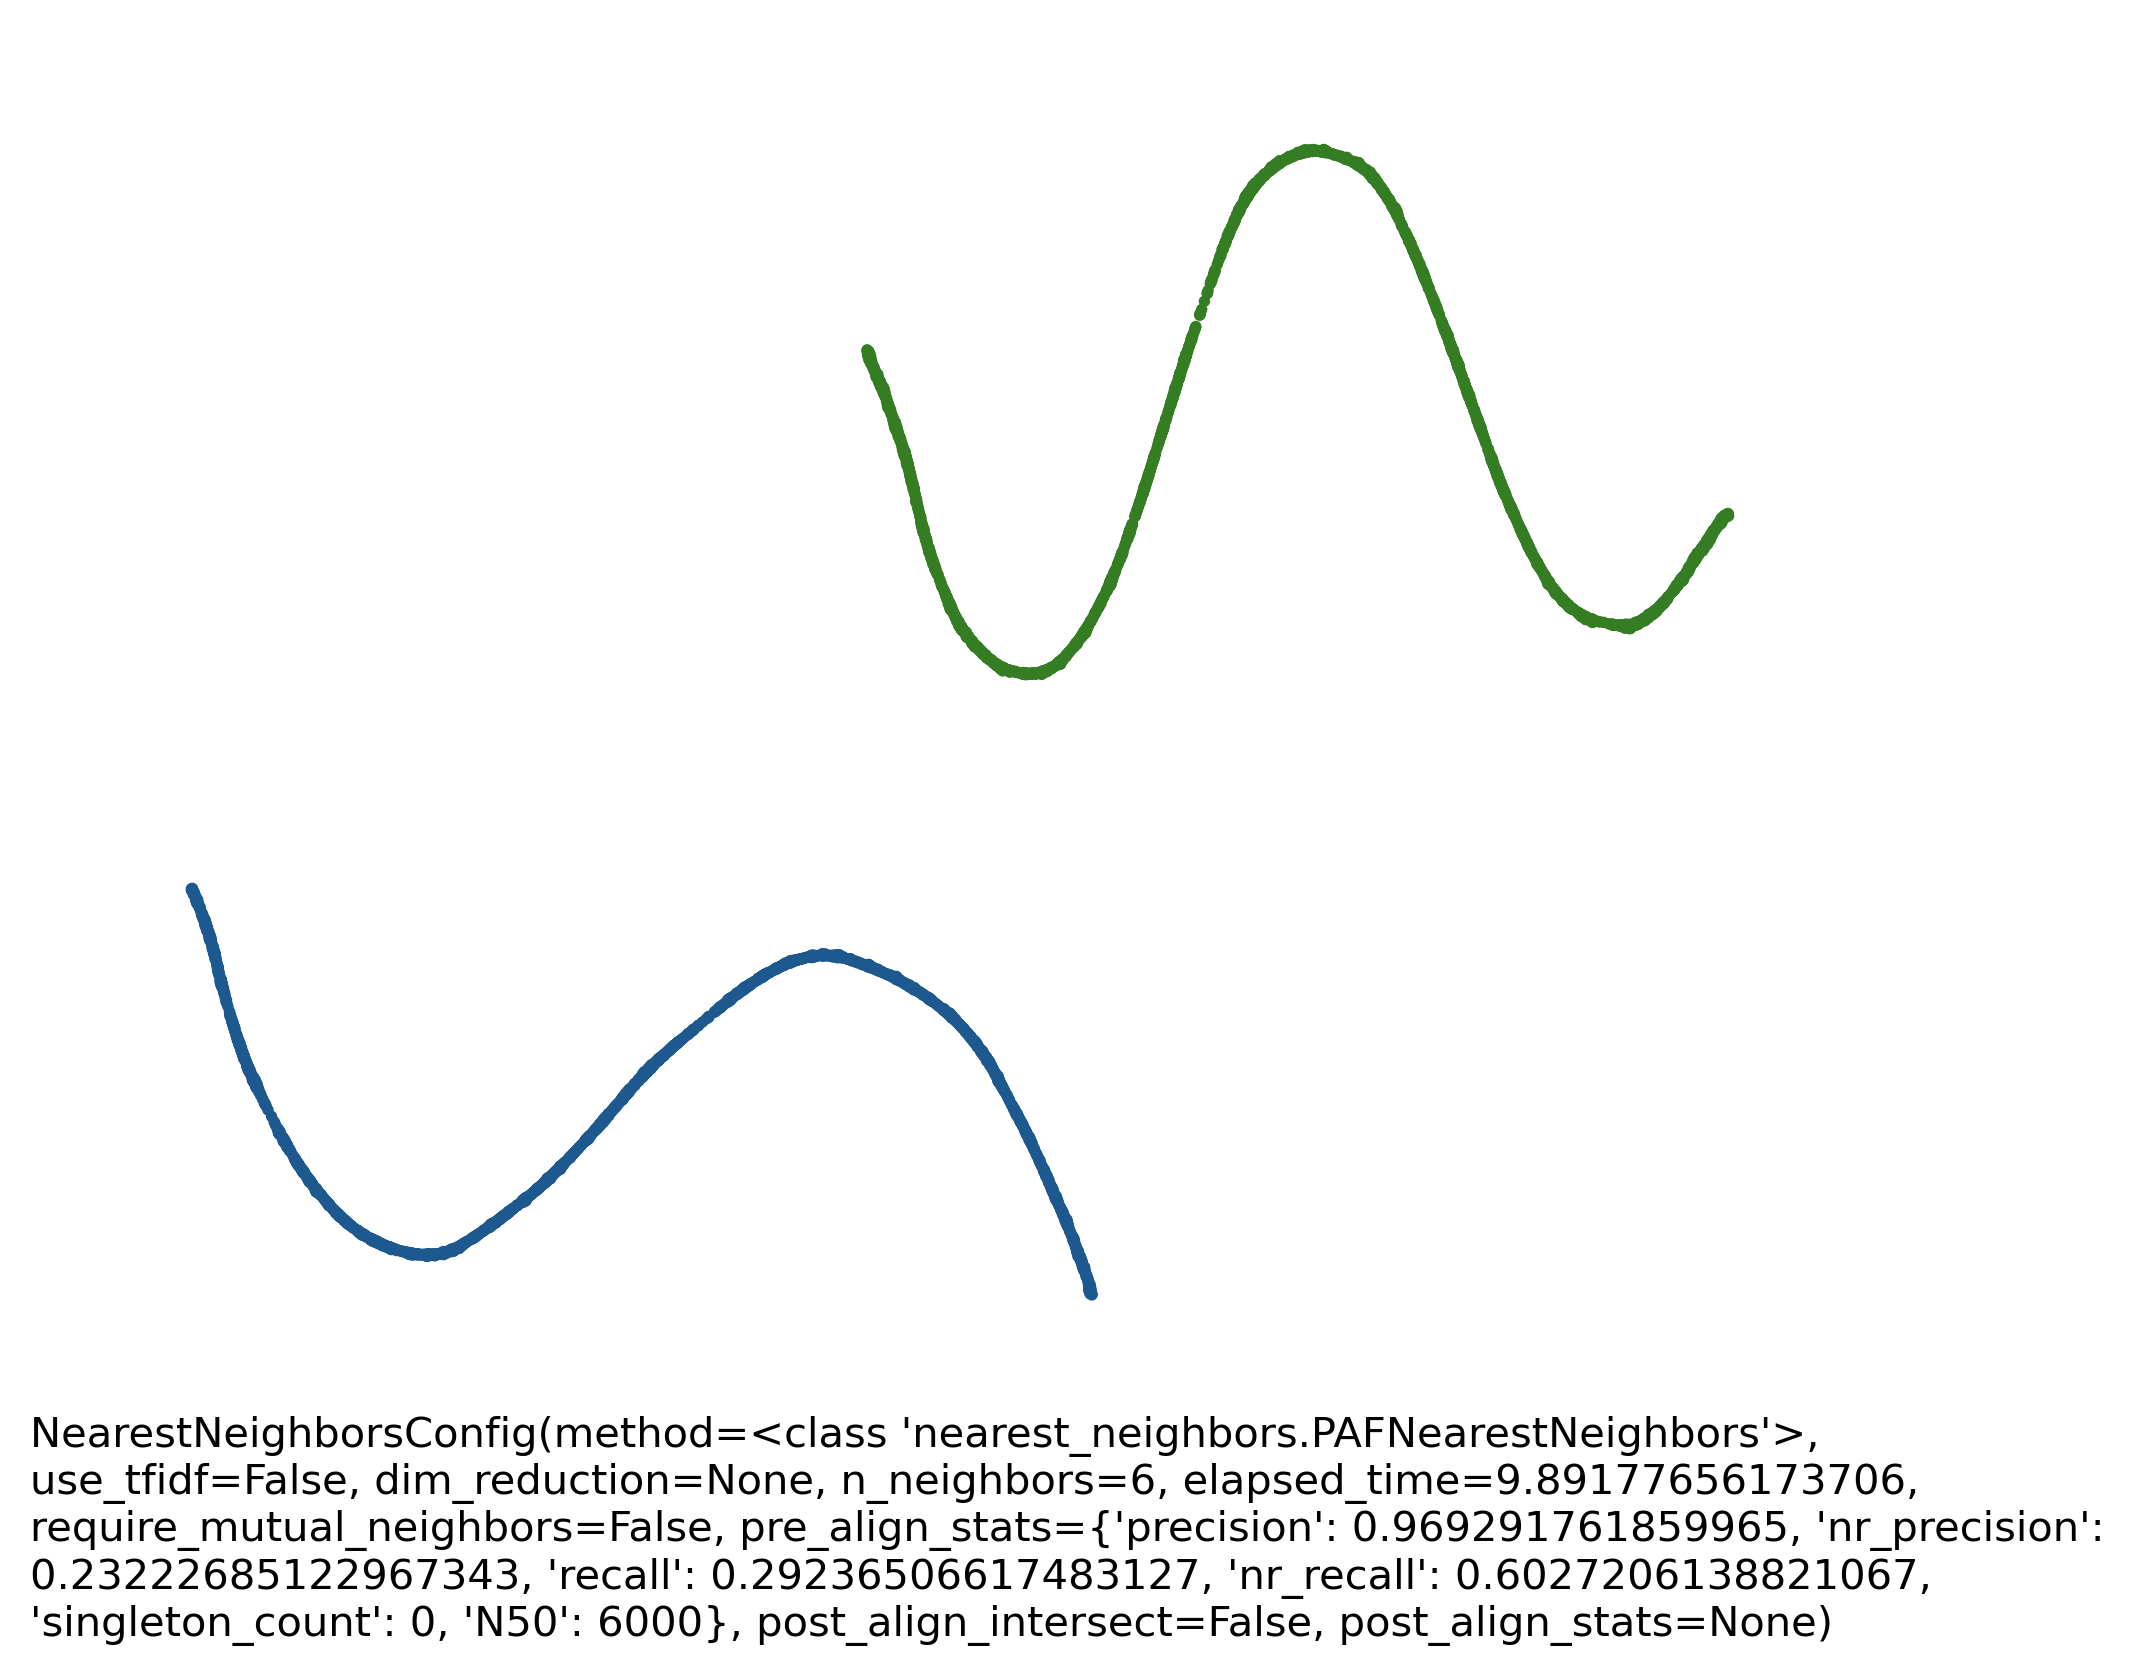

In [17]:
%%time
plot_configs(
    configs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=16
)